<a href="https://colab.research.google.com/github/Fabian-lewis/medical-diagnostic-pricing-audit/blob/main/reverse_engineering_pricing_logic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Objective

Answer this question:

    “Is the high pricing of obese smokers coming from:
     - smoking alone,
     - BMI alone,
     - or the interaction between the two?”

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [2]:
## Load the data

from google.colab import files

# upload the data
uploaded = files.upload()

# Get the filename
filename = list(uploaded.keys())[0]

# Read the file
df = pd.read_csv(filename)

# Copy the data
data = df.copy()

data.head()

Saving cleaned_insurance_data.csv to cleaned_insurance_data.csv


,Unnamed: 0,age,sex,bmi,children,smoker,region,charges,smoker_binary,bmi_category,bmi_smoker_interaction
0,0,19,female,27.900,0,yes,southwest,16884.92400,1,Overweight,27.9
1,1,18,male,33.770,1,no,southeast,1725.55230,0,Obese,0.0
2,2,28,male,33.000,3,no,southeast,4449.46200,0,Obese,0.0
3,3,33,male,22.705,0,no,northwest,21984.47061,0,Normal,0.0
4,4,32,male,28.880,0,no,northwest,3866.85520,0,Overweight,0.0


In [3]:
# Convert Sex & Region to Categorical
data['sex'] = data['sex'].astype('category')
data['region'] = data['region'].astype('category')

In [8]:
# =========================================================
# BASELINE MODEL: Independent Effects Only
# =========================================================
# Purpose:
# - Establish a reference pricing model
# - Assume smoking and BMI affect costs independently
# - Identify whether this assumption is sufficient
# =========================================================

baseline_model = smf.ols(
    formula="""
        charges ~
        age +
        sex +
        bmi +
        children +
        smoker_binary +
        region
    """,
    data=data
).fit()

# Interpretation:
# - Coefficients show average change in medical charges
# - smoker_binary reflects an average smoking surcharge
#   regardless of BMI level

print("BASELINE REGRESSION RESULTS (No Interaction)")
display(baseline_model.summary())

# Extract coefficients for easy comparison
baseline_coefficients = baseline_model.params.to_frame(
    name="Baseline_Coefficient"
)
baseline_coefficients


BASELINE REGRESSION RESULTS (No Interaction)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.8
Date:                Wed, 14 Jan 2026   Prob (F-statistic):               0.00
Time:                        21:57:34   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -1.194e+04    987.819    -12.086      0.000   -1.39e+04      -1e+04
sex[T.male]          -131.3144    332.945     -0.394      0.693    -784.470     521.842
region[T.northwest]  -352.9639    476.276     -0.741      0.459   -1287.298     581.370
region[T.southeast] -1035.0220    478.692     -2.162      0.031   -1974.097     -95.947
region[T.southwest]  -960.0510    477.933     -2.009      0.045   -1897.636     -22.466
age                   256.8564     11.899     21.587      0.000     233.514     280.199
bmi                   339.1935     28.599     11.860      0.000     283.088     395.298
children              475.5005    137.804      3.451      0.001     205.163     745.838
smoker_binary        2.385e+04    413.153     57.723      0.000     2.3e+04    2.47e+04
==============================================================================
Omnibus:                      300.366   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              718.887
Skew:                           1.211   Prob(JB):                    7.86e-157
Kurtosis:                       5.651   Cond. No.                         311.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,Baseline_Coefficient
Intercept,-11938.538576
sex[T.male],-131.314359
region[T.northwest],-352.963899
region[T.southeast],-1035.022049
region[T.southwest],-960.050991
age,256.856353
bmi,339.193454
children,475.500545
smoker_binary,23848.534542


In [9]:
# =========================================================
# INTERACTION MODEL: BMI × Smoking
# =========================================================
# Purpose:
# - Capture compounded risk between BMI and smoking
# - Explain high costs among obese smokers
# - Improve explanatory power over baseline model
# =========================================================

interaction_model = smf.ols(
    formula="""
        charges ~
        age +
        bmi +
        smoker_binary +
        bmi:smoker_binary +
        children +
        region
    """,
    data=df
).fit()

# Interpretation guide:
# - bmi: effect of BMI for non-smokers
# - smoker_binary: smoking surcharge at baseline BMI
# - bmi:smoker_binary: additional BMI cost for smokers

print("INTERACTION REGRESSION RESULTS (BMI × Smoking)")
display(interaction_model.summary())

# Extract coefficients for reporting
interaction_coefficients = interaction_model.params.to_frame(
    name="Interaction_Coefficient"
)
interaction_coefficients


INTERACTION REGRESSION RESULTS (BMI × Smoking)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     875.4
Date:                Wed, 14 Jan 2026   Prob (F-statistic):               0.00
Time:                        21:58:49   Log-Likelihood:                -13250.
No. Observations:                1338   AIC:                         2.652e+04
Df Residuals:                    1329   BIC:                         2.656e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -2453.5639    857.695     -2.861      0.004   -4136.147    -770.981
region[T.northwest]  -581.7043    381.215     -1.526      0.127   -1329.554     166.145
region[T.southeast] -1207.0113    383.109     -3.151      0.002   -1958.576    -455.446
region[T.southwest] -1227.6015    382.576     -3.209      0.001   -1978.120    -477.083
age                   264.0422      9.522     27.729      0.000     245.362     282.723
bmi                    22.6149     25.620      0.883      0.378     -27.645      72.875
smoker_binary       -2.031e+04   1648.861    -12.317      0.000   -2.35e+04   -1.71e+04
bmi:smoker_binary    1438.1084     52.630     27.325      0.000    1334.862    1541.355
children              512.7134    110.266      4.650      0.000     296.398     729.028
==============================================================================
Omnibus:                      719.320   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4430.079
Skew:                           2.521   Prob(JB):                         0.00
Kurtosis:                      10.352   Cond. No.                         662.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,Interaction_Coefficient
Intercept,-2453.563926
region[T.northwest],-581.704315
region[T.southeast],-1207.011260
region[T.southwest],-1227.601470
age,264.042212
bmi,22.614913
smoker_binary,-20309.092365
bmi:smoker_binary,1438.108413
children,512.713416


In [10]:
# Extract coefficients from both models
baseline_coefs = baseline_model.params.to_frame(name="Baseline")
interaction_coefs = interaction_model.params.to_frame(name="Interaction")

# Merge into one table for easy comparison
model_comparison = baseline_coefs.merge(
    interaction_coefs,
    left_index=True,
    right_index=True
)

# display
print("MODEL COMPARISON: Baseline vs Interaction")
display(model_comparison)

MODEL COMPARISON: Baseline vs Interaction


,Baseline,Interaction
Intercept,-11938.538576,-2453.563926
region[T.northwest],-352.963899,-581.704315
region[T.southeast],-1035.022049,-1207.011260
region[T.southwest],-960.050991,-1227.601470
age,256.856353,264.042212
bmi,339.193454,22.614913
children,475.500545,512.713416
smoker_binary,23848.534542,-20309.092365


### Model Comparison Summary

1.Baseline model:


    Assumes smoking and BMI affect costs independently.

    Smoking shows a large, flat surcharge.

    BMI increases charges for everyone at the same rate.

2.Interaction model (BMI × Smoking):

    Allows the effect of BMI to differ between smokers and non-smokers.

    Smoking coefficient decreases substantially.

    BMI alone is not significant for non-smokers.

    BMI × Smoker coefficient is large and highly significant
    → this captures the “cost cliff” for obese smokers.


---


#### Interpretation:

    Costs increase steadily with BMI for non-smokers, but for smokers,
    higher BMI leads to a dramatic rise in charges.
    
    The interaction term explains the disproportionate risk among obese smokers
    that the baseline model could not capture.

---
#### Key takeaway:

    The interaction model better reflects reality and provides strong evidence for pricing adjustments.


    Being both a smoker and obese is far more expensive than either factor alone.

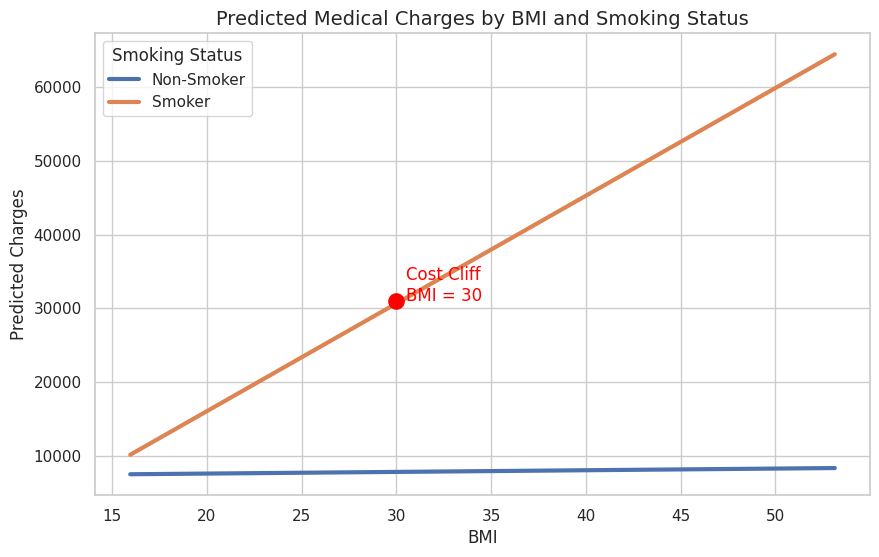

In [17]:
## INTERACTION PLOT: Predicted Charges vs BMI

sns.set(style="whitegrid")

# Create BMI range for predictions
bmi_range = np.linspace(df['bmi'].min(), df['bmi'].max(), 100)

# Build prediction dataframe
pred_df = pd.DataFrame({
    'age': df['age'].median(),           # use median age
    'children': df['children'].median(), # use median children
    'region': 'southeast',               # reference region
    'bmi': np.tile(bmi_range, 2),
    'smoker_binary': [0]*100 + [1]*100   # 0 = Non-Smoker, 1 = Smoker
})

#  Predict charges using the interaction model
pred_df['predicted_charges'] = interaction_model.predict(pred_df)

# Label for plotting
pred_df['Smoker Status'] = np.where(pred_df['smoker_binary']==1, 'Smoker', 'Non-Smoker')

# Cost cliff annotation at BMI 30
cliff_bmi = 30
cliff_charge = pred_df.loc[
    (pred_df['Smoker Status']=='Smoker') &
    (pred_df['bmi'] >= cliff_bmi),
    'predicted_charges'
].iloc[0]

#  Plot
plt.figure(figsize=(10,6))
sns.lineplot(data=pred_df, x='bmi', y='predicted_charges', hue='Smoker Status', linewidth=3)

# Annotate cost cliff
plt.scatter(cliff_bmi, cliff_charge, color='red', s=120, zorder=5)
plt.text(cliff_bmi+0.5, cliff_charge, f"Cost Cliff\nBMI = {cliff_bmi}", color='red', fontsize=12)

plt.title("Predicted Medical Charges by BMI and Smoking Status", fontsize=14)
plt.xlabel("BMI")
plt.ylabel("Predicted Charges")
plt.legend(title="Smoking Status")
plt.show()

### Interaction Plot: BMI × Smoking

This plot shows predicted medical charges for non-smokers and smokers:

- **Non-smokers:** Costs increase steadily as BMI rises.  
- **Smokers:** Costs remain moderate at lower BMI but increase sharply beyond BMI = 30 (cost cliff).  
- The red dot highlights this critical BMI threshold, demonstrating the amplified risk when smoking and high BMI occur together.
